# Env

In [80]:
%%capture
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import warnings

#import ssl; ssl._create_default_https_context = ssl._create_unverified_context
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sciRED import ensembleFCA as efca
from sciRED import glm
from sciRED import rotations as rot
from sciRED import metrics as met

from sciRED.utils import preprocess as proc
from sciRED.utils import visualize as vis
from sciRED.utils import corr
from sciRED.examples import ex_preprocess as exproc
from sciRED.examples import ex_visualize as exvis

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

In [32]:
import os

PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = os.path.join(PROJECT_DIR, "combine_data/ANALYSIS/Enrichment/sciRED")
DATA_DIR = os.path.join(PROJECT_DIR, "combine_data", "results_from_raw")

os.chdir(WORKING_DIR)

In [33]:
np.random.seed(10)
NUM_COMPONENTS = 30
NUM_GENES = 2000
NUM_COMP_TO_VIS = 3

# Load Data

In [34]:
%%capture
data_file_path = os.path.join(DATA_DIR, "annotation_final.h5ad")
data = exproc.import_AnnData(data_file_path)

In [35]:
# print(f"Before filtering: {data.shape}")
# data = data[:, ~data.var_names.str.startswith("mt-")].copy()
# print(f"After filtering: {data.shape}")

In [36]:
data

AnnData object with n_obs × n_vars = 28026 × 26870
    obs: 'sample', 'condition', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.4', 'ISO_majority_voting', 'ISO_conf_score', 'DG_majority_voting', 'DG_conf_score', 'mapmycells_first_layer', 'mapmycells_second_layer', 'cell_type_L1', 'cell_type_L2', 'cell_type_L2_new', 'highlight'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'DG_majority_voting_colors', 'ISO_majority_voting_colors', 'cell_type_L1_colors', 'cell_type_L2_colors', 'cell_type_L2_new_colors', 'condition_colors', 'genotype_colors', 'highlight_colors', 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [37]:
# print(type(data.obs["condition"]))
# print(data.X[:3, :3])

In [38]:
# data_raw = ad.AnnData(data.raw.X.copy()) # type: ignore
# data_raw.obs_names = data.obs_names # type: ignore
# data_raw.var_names = data.raw.var_names # type: ignore

# # Ensure the gene order matches the main data object
# data_raw = data_raw[:, data.var_names].copy() # type: ignore
# data.X = data_raw.X.copy() 

In [39]:
# print(data.obs["genotype"].unique())
# print(data.obs["condition"].unique())
# print(data.obs["cell_type_L2_new"].unique())

In [40]:
data = data[data.obs["genotype"]=="Emx1"]
print(data.shape)
data = data[data.obs["cell_type_L2_new"]=="Mature GC"]
print(data.shape)

print("\nValue counts for 'condition' after filtering:")
print(data.obs['condition'].value_counts())

(10233, 26870)
(745, 26870)

Value counts for 'condition' after filtering:
condition
Control    477
Mutant     268
Name: count, dtype: int64


In [41]:
data, gene_idx = proc.get_sub_data(data, num_genes=NUM_GENES) # subset the data to num_genes HVGs
y, genes, num_cells, num_genes = proc.get_data_array(data)

745 2000


In [42]:
data

View of AnnData object with n_obs × n_vars = 745 × 2000
    obs: 'sample', 'condition', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden_0.4', 'ISO_majority_voting', 'ISO_conf_score', 'DG_majority_voting', 'DG_conf_score', 'mapmycells_first_layer', 'mapmycells_second_layer', 'cell_type_L1', 'cell_type_L2', 'cell_type_L2_new', 'highlight'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'DG_majority_voting_colors', 'ISO_majority_voting_colors', 'cell_type_L1_colors', 'cell_type_L2_colors', 'cell_type_L2_new_colors', 'condition_colors', 'genotype_colors', 'highlight_colors', 'hvg', 'leiden_0.4', 'leiden_0.4_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [43]:
print(f"gene_idx: {gene_idx[:10]} \n")
print(f"y[:5][:5] {y[:5][:5]}, y.shape: {y.shape} \n")
print(f"genes[:5] {genes[:5]} \n")
print(f"num_cells: {num_cells}\n") 
print(f"num_genes: {num_genes} \n")

gene_idx: [ 0 10 13 15 17 32 33 35 36 40] 

y[:5][:5] [[1.8793719  0.58376193 0.94993436 ... 3.0732496  2.9970553  0.58376193]
 [2.056254   0.         1.3155105  ... 1.3155105  0.         0.        ]
 [3.1280794  0.         1.036444   ... 0.         0.         2.1134439 ]
 [2.3434834  0.         0.8524354  ... 1.3058171  1.616623   2.205205  ]
 [1.2066276  0.7752327  0.7752327  ... 0.7752327  0.7752327  1.2066276 ]], y.shape: (745, 2000) 

genes[:5] Index(['Xkr4', 'Atp6v1h', 'Rb1cc1', 'St18', 'Pcmtd1'], dtype='object') 

num_cells: 745

num_genes: 2000 



# **Step 1: Factor discovery:**

In [44]:
data.obs["total_counts"].head()

AAACGCGCACGGTACT-1-0    12614.0
AAAGCAAGTTCCTGAT-1-0     7337.0
AAAGCTTGTAGGTTTG-1-0     5497.0
AAAGGAGCATCCATCT-1-0     7433.0
AAATGCCTCCTACCTA-1-0     8539.0
Name: total_counts, dtype: float32

In [45]:
#### Design matrix - including library size
x = data.obs["total_counts"]
x = sm.add_constant(x) ## adding the intercept
print(x[:5])

                      const  total_counts
AAACGCGCACGGTACT-1-0    1.0       12614.0
AAAGCAAGTTCCTGAT-1-0    1.0        7337.0
AAAGCTTGTAGGTTTG-1-0    1.0        5497.0
AAAGGAGCATCCATCT-1-0    1.0        7433.0
AAATGCCTCCTACCTA-1-0    1.0        8539.0


In [46]:
glm_fit_dict = glm.poissonGLM(y, x)
resid_pearson = glm_fit_dict['resid_pearson'] 
print('pearson residuals: ', resid_pearson.shape) # numpy array of shape (num_genes, num_cells)
y = resid_pearson.T
print('y shape: ', y.shape)

time to fit the model:  5.464410781860352
pearson residuals:  (2000, 745)
y shape:  (745, 2000)


Apply PCA to the extracted residuals. PCA factors are then rotated (varimax or promax) to improve interpretibility. 

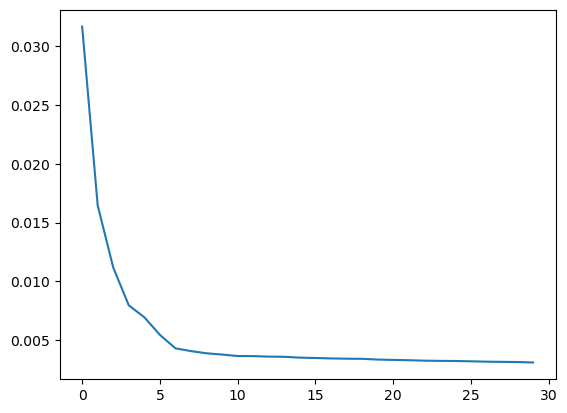

In [47]:
################################################
#### Running PCA on the pearson residual ######
################################################

### using pipeline to scale the gene expression data first
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=NUM_COMPONENTS))])
pca_scores = pipeline.fit_transform(y)
pca = pipeline.named_steps['pca']
pca_loading = pca.components_
pca_loading.shape
pca_plot = plt.plot(pca.explained_variance_ratio_)

In [48]:
unique_condition= data.obs["condition"].unique()
cmap = plt.get_cmap("tab10")
condition_color_dict = {condition: cmap(i % cmap.N) for i, condition in enumerate(unique_condition)}
condition_colors = [condition_color_dict[con] for con in data.obs["condition"]]

In [49]:
plt_legend_condition= exvis.get_legend_patch(data.obs["condition"], condition_colors )

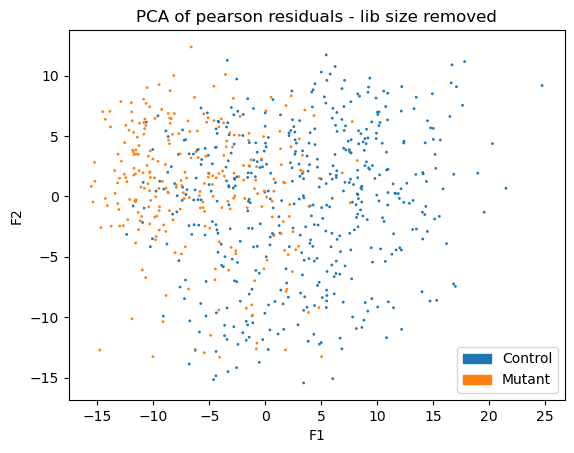

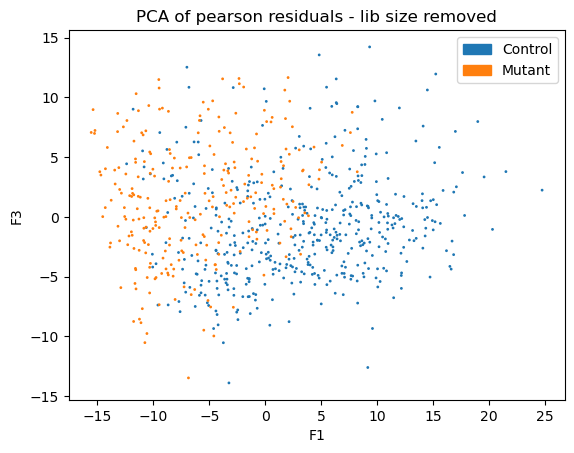

In [50]:
title = 'PCA of pearson residuals - lib size removed'
vis.plot_pca(pca_scores, NUM_COMP_TO_VIS, 
               cell_color_vec= condition_colors, 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_condition)    

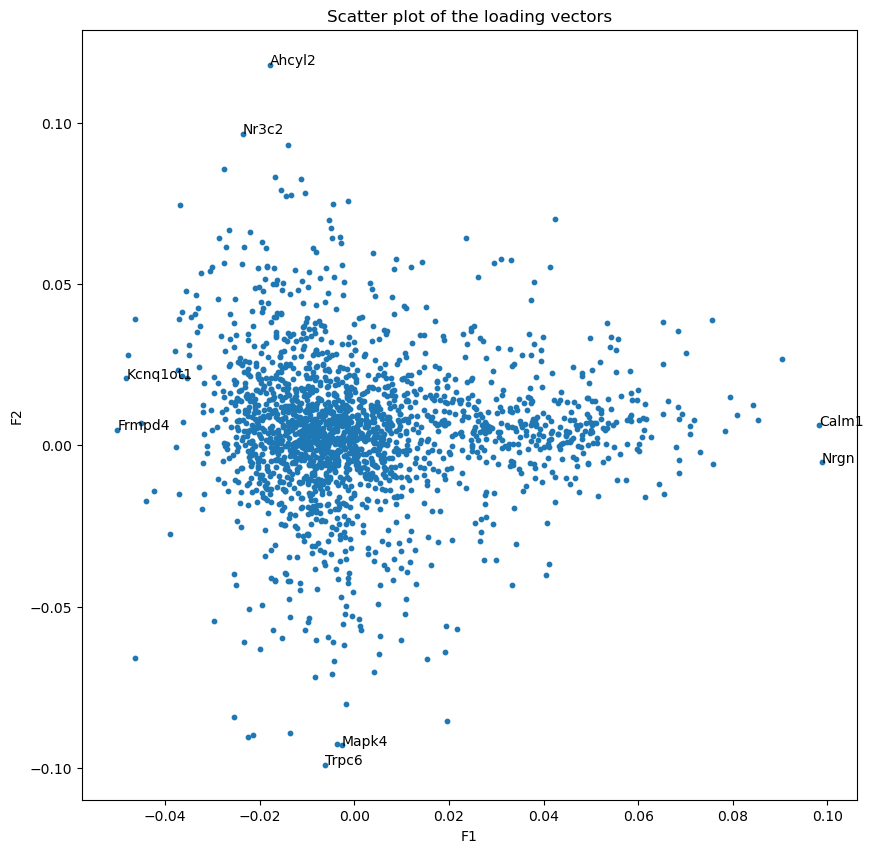

In [51]:
vis.plot_factor_loading(pca_loading.T, genes, 0, 1, fontsize=10, 
                    num_gene_labels=2,
                    title='Scatter plot of the loading vectors', 
                    label_x=True, label_y=True)

embedding shape:  (745, 2)


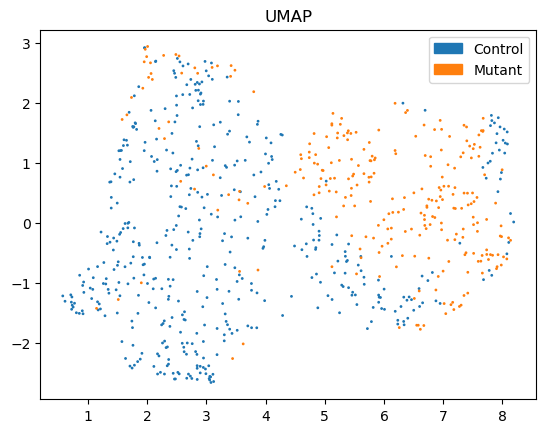

In [52]:
vis.plot_umap(pca_scores, 
              title='UMAP',
              cell_color_vec= condition_colors, 
               legend_handles=True, plt_legend_list=plt_legend_condition)

In [53]:
######## Applying varimax rotation to the factor scores
rotation_results_varimax = rot.varimax(pca_loading.T)
varimax_loading = rotation_results_varimax['rotloading']
pca_scores_varimax = rot.get_rotated_scores(pca_scores, rotation_results_varimax['rotmat'])

In [54]:
print(f"rotation_results_varimax.keys(): {rotation_results_varimax.keys()}")
print(f"varimax_loading.shape: {varimax_loading.shape}")
print(f"pca_scores_varimax.shape: {pca_scores_varimax.shape}")

rotation_results_varimax.keys(): dict_keys(['rotloading', 'rotmat'])
varimax_loading.shape: (2000, 30)
pca_scores_varimax.shape: (745, 30)


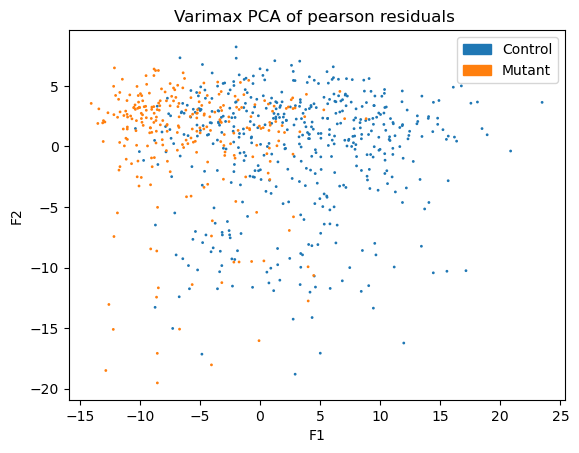

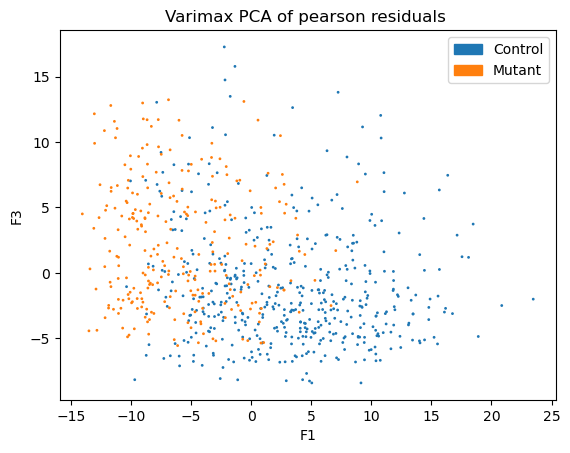

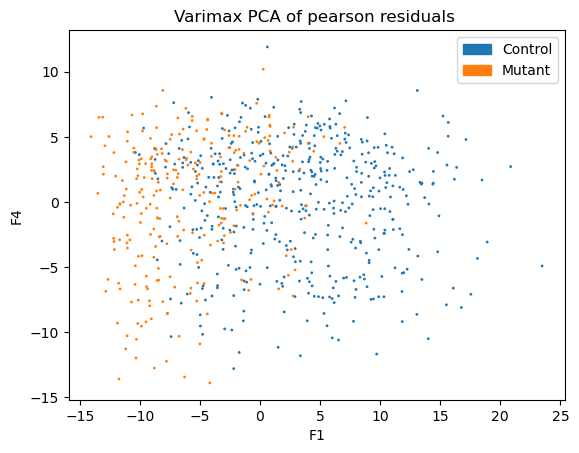

In [55]:
title = 'Varimax PCA of pearson residuals '
vis.plot_pca(pca_scores_varimax, NUM_COMP_TO_VIS+1, 
               cell_color_vec= condition_colors, 
               legend_handles=True,
               title=title,
               plt_legend_list=plt_legend_condition)

In [56]:
##### Setting the factor scores an loadings to be used in step-2 based on Varimax factors
factor_loading = rotation_results_varimax['rotloading']
factor_scores = pca_scores_varimax

In [57]:
# print(factor_scores.shape)
# print(factor_scores[:2][:2])

# **Step 2: Factor-Covariate Association**:

- To identify factors that explain a specific covariate, sciRED employs an ensemble classifier as a second step. 
- Apply four machine learning classifiers to predict covariate labels based on the cell-specific factor weights. 
- Feature importance scores are obtained from each classifier are then scaled based on one out of three scaling methods, and averaged to generate a consensus association score. 
- The consensus scores for every combination of covariate and factor are aggregated into the factor-covariate association table (FCAT) and visualized in a heatmap. 
- The FCAT function takes-in the cell-level labels for each covariate. 
- The resulting tables for each covariate are then concatenated and visualized as a heatmap.  

In [58]:
# print(data.obs["condition"].shape)
# print(type(data.obs["condition"]))

In [59]:
%%capture
####################################
#### FCAT score calculation ######
####################################

### FCAT needs to be calculated for each covariate separately
fcat_condition = efca.FCAT(data.obs['condition'], factor_scores, scale='standard', mean='arithmatic')

### concatenate FCAT table for protocol and cell line
fcat = fcat_condition

In [60]:
fcat_sorted_desc = fcat.loc[:, fcat.loc['Control'].sort_values(ascending=False).index]
print("Sorted by Control values (descending):")
fcat_sorted_desc.iloc[:, :5]

Sorted by Control values (descending):


,F1,F7,F13,F30,F4
Control,3.526037,2.449242,0.754828,0.706667,0.686541
Mutant,3.523892,2.453513,0.754269,0.705870,0.685880


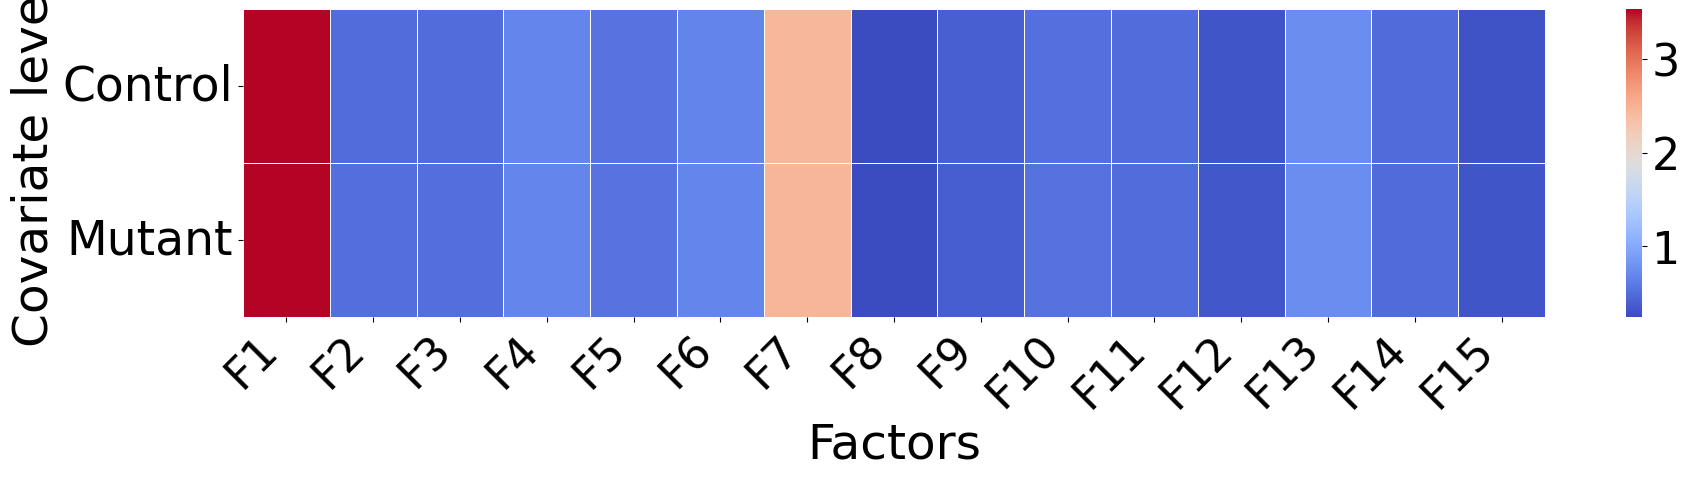

In [61]:
### visualize the first 15 factors
vis.plot_FCAT(fcat.iloc[:,0:15],title='', color='coolwarm',x_axis_fontsize=35, 
              y_axis_fontsize=35, title_fontsize=35,
              x_axis_tick_fontsize=32, y_axis_tick_fontsize=34)

# **Step 2a: Visualize Factor Directionality**

With the original implementation FCAT, for the binary 'condition' covariate, we need to check the direction of the effect for the factors of interest.   
This boxplot shows the distribution of factor scores for each condition.

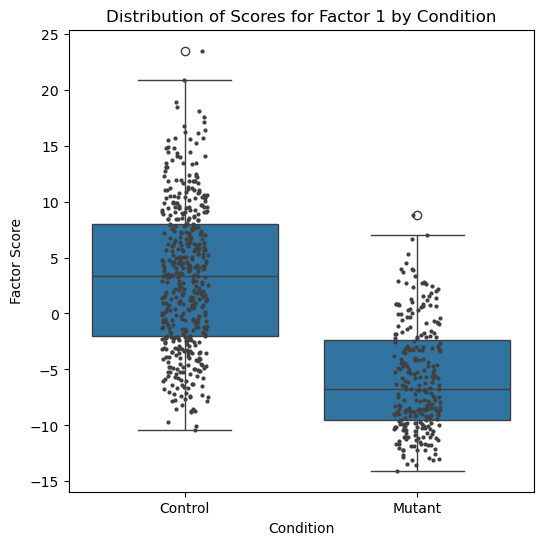

In [62]:
INTERESTING_FACTOR_ID = 0

# Create a DataFrame for easy plotting with seaborn
plot_df = pd.DataFrame({
    f'Factor_{INTERESTING_FACTOR_ID + 1}_Scores': factor_scores[:, INTERESTING_FACTOR_ID],
    'Condition': data.obs['condition'].values
})

# Create the boxplot
plt.figure(figsize=(6, 6))
sns.boxplot(x='Condition', y=f'Factor_{INTERESTING_FACTOR_ID + 1}_Scores', data=plot_df)
# Add individual data points for better visualization
sns.stripplot(x='Condition', y=f'Factor_{INTERESTING_FACTOR_ID + 1}_Scores', data=plot_df, color=".25", size=3)
plt.title(f'Distribution of Scores for Factor {INTERESTING_FACTOR_ID + 1} by Condition')
plt.ylabel('Factor Score')
plt.xlabel('Condition')
plt.show()

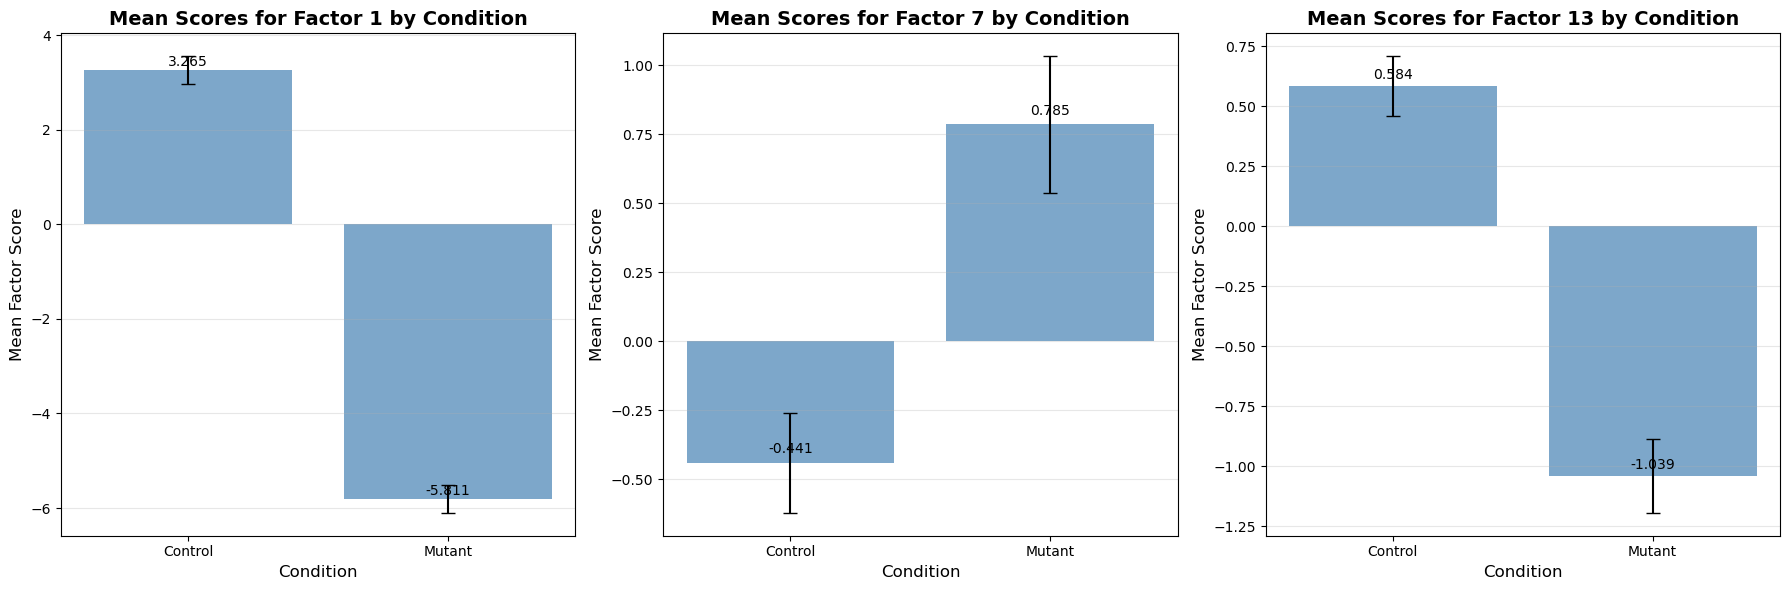

In [63]:
# Define the interesting factor IDs
INTERESTING_FACTOR_IDS = [0, 6, 12]

# Create subplots for the three factors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, factor_id in enumerate(INTERESTING_FACTOR_IDS):
    # Create a DataFrame for the current factor
    plot_df = pd.DataFrame({
        f'Factor_{factor_id + 1}_Scores': factor_scores[:, factor_id],
        'Condition': data.obs['condition'].values
    })
    
    # Calculate mean and standard error for each condition
    summary_stats = plot_df.groupby(
        'Condition', observed=False
    )[f'Factor_{factor_id + 1}_Scores'].agg(['mean', 'sem']).reset_index()
    
    # Create the bar plot
    ax = axes[idx]
    bars = ax.bar(summary_stats['Condition'], summary_stats['mean'], 
                  yerr=summary_stats['sem'], capsize=5, alpha=0.7, color='steelblue')
    
    # Customize the plot
    ax.set_title(f'Mean Scores for Factor {factor_id + 1} by Condition', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Factor Score', fontsize=12)
    ax.set_xlabel('Condition', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on top of bars
    for bar, mean_val in zip(bars, summary_stats['mean']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + summary_stats['sem'].max()*0.1, 
                f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Significant vs non-significant associations between factors and covariates are determined using a threshold automatically obtained using Otsu’s method.   
This threshold can assist in defining the number of inferred factors (K).   
For example, if a considerable proportion of factors fail to align with any covariates, it may prompt the to reduce K.   

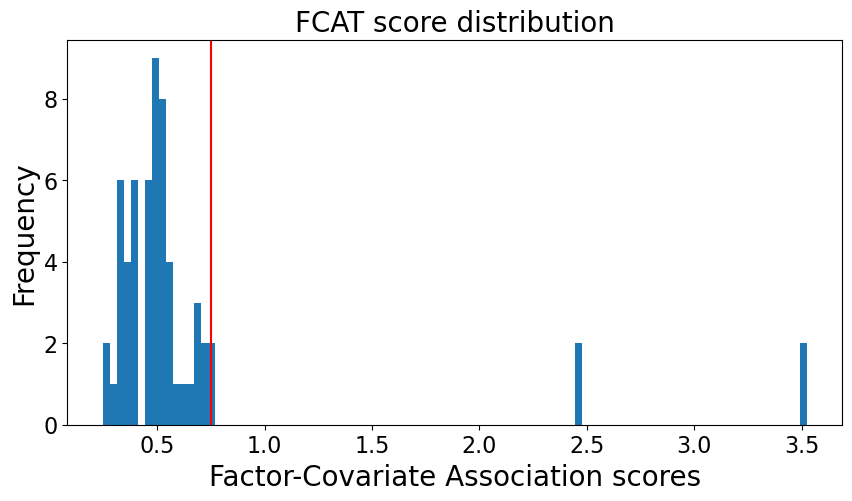

In [65]:
## rownames of the FCAT table
all_covariate_levels = fcat.index.values

### using Otsu's method to calculate the threshold
threshold = efca.get_otsu_threshold(fcat.values.flatten())

vis.plot_histogram(fcat.values.flatten(),
                   xlabel='Factor-Covariate Association scores',
                   title='FCAT score distribution',
                   threshold=threshold)



In [81]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module="numpy.core.fromnumeric")
    matched_factor_dist, percent_matched_fact = efca.get_percent_matched_factors(fcat, threshold)
    matched_covariate_dist, percent_matched_cov = efca.get_percent_matched_covariates(fcat, threshold=threshold)

print('percent_matched_fact: ', percent_matched_fact)
print('percent_matched_cov: ', percent_matched_cov)

percent_matched_fact:  10.0
percent_matched_cov:  100.0


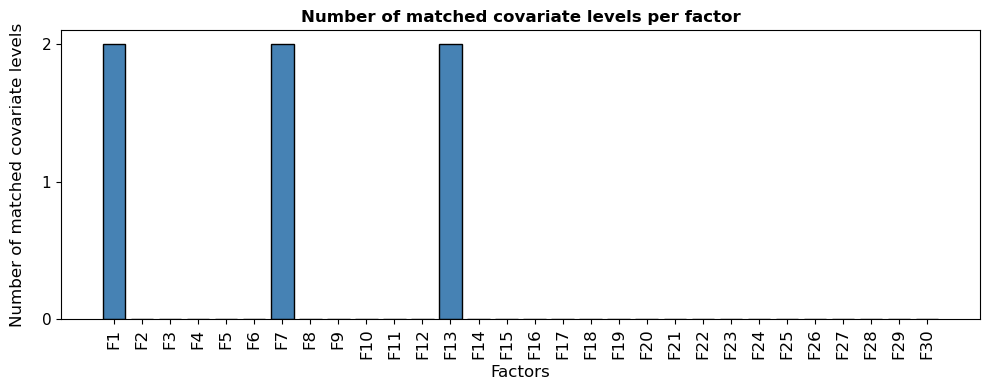

In [88]:
def plot_matched_factor_dist(matched_factor_dist, title='', save=False, save_path='./file.pdf', fontsize=18):
    """
    Plot the distribution of the number of matched covariate levels for each factor.

    Parameters
    ----------
    matched_factor_dist : array-like or Pandas Series
        Distribution of the number of matched covariate levels for each factor.
    title : str, optional
        Title of the plot. If not provided, a default title is used.
    save : bool, optional
        Whether to save the plot to a file.
    save_path : str, optional
        Path to save the plot if 'save' is True.
    """
    # Determine dynamic figure width based on the number of factors
    fig_width = np.round(len(matched_factor_dist) / 3)
    fig, ax = plt.subplots(figsize=(fig_width, 4))
    
    # Plot the bar chart
    x_positions = np.arange(len(matched_factor_dist))
    ax.bar(x_positions, matched_factor_dist, color='steelblue', edgecolor='black')
    
    # Set x-axis ticks and labels as F1, F2, ..., etc.
    labels = [f'F{i}' for i in range(1, len(matched_factor_dist) + 1)]
    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=90, fontsize=fontsize)
    
    # Set labels and title similar to file_context_0 formatting
    ax.set_ylabel('Number of matched covariate levels', fontsize=fontsize, labelpad=12)
    ax.set_xlabel('Factors', fontsize=fontsize)
    default_title = 'Number of matched covariate levels per factor'
    ax.set_title(title if title else default_title, fontsize=fontsize, fontweight='bold')
    
    # Set y-axis ticks to show integer values
    ax.set_yticks(np.arange(0, max(matched_factor_dist) + 1, 1))
    ax.tick_params(axis='y', labelsize=11)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

plot_matched_factor_dist(matched_factor_dist, fontsize=12)

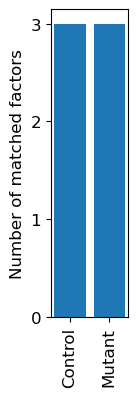

In [94]:
def plot_matched_covariate_dist(matched_covariate_dist, covariate_levels , title='',
                                save=False, save_path='./file.pdf', fontsize=12):
      """
        plot the distribution of the number of matched factors for each covariate level
        matched_covariate_dist: the distribution of the number of matched factors for each covariate level
        covariate_levels: the covariate levels
        title: the title of the plot
        save: whether to save the plot
        save_path: the path to save the plot

      """
      plt.figure(figsize=(np.round(len(matched_covariate_dist)/3),4))
      plt.bar(np.arange(len(matched_covariate_dist)), matched_covariate_dist)
      ### add covariate levels to the xticks
      plt.xticks(np.arange(len(matched_covariate_dist)), covariate_levels)

      ### make the xticks vertical and set the fontsize to 14
      plt.xticks(rotation=90, fontsize=fontsize)
      #plt.xlabel('Number of matched factors')
      ## set y ticks as digits and remove the decimal points and half points
      plt.yticks(np.arange(0, max(matched_covariate_dist)+1, 1), fontsize=fontsize) 
      plt.ylabel('Number of matched factors', fontsize=fontsize)
      plt.title(title)
      
      if save:
        plt.savefig(save_path, bbox_inches='tight')
      plt.show()

plot_matched_covariate_dist(
    matched_covariate_dist, 
    covariate_levels=all_covariate_levels,
    fontsize=12
)

Check the correlation between the factors and the library size which was regressed out

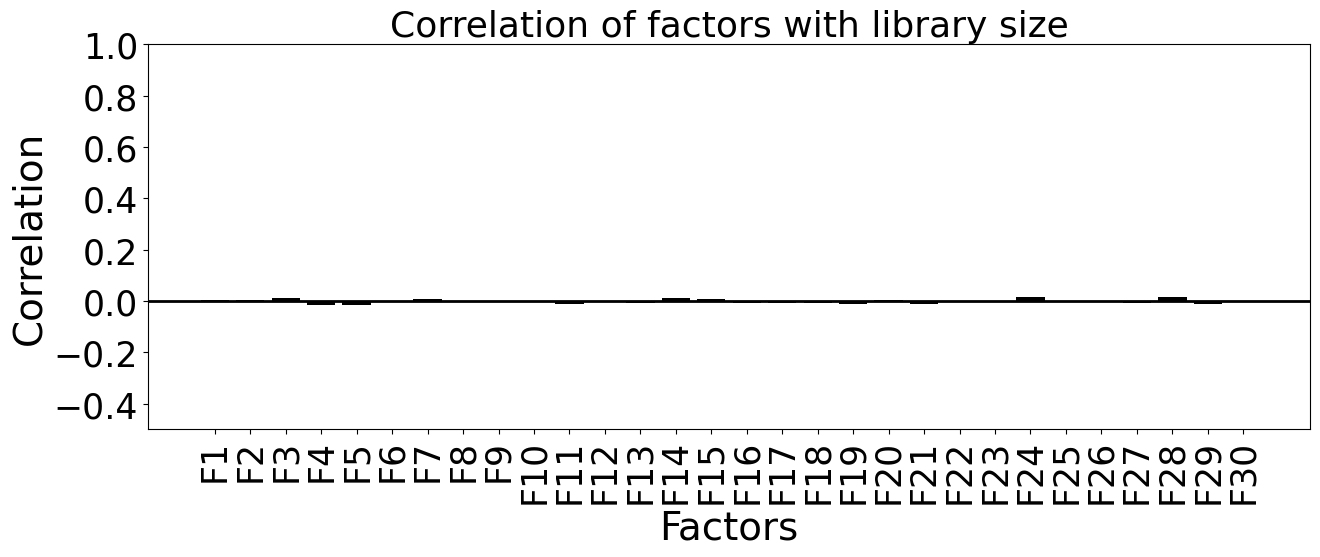

In [96]:
factor_libsize_correlation = corr.get_factor_libsize_correlation(factor_scores, library_size = data.obs["total_counts"])
vis.plot_factor_cor_barplot(factor_libsize_correlation, 
             title='Correlation of factors with library size', 
             y_label='Correlation', x_label='Factors')

# **Step 3: Interpretability scores:** 
The third step of sciRED involves quantifying the interpretability of identified factors.    
Defined four categories of metrics: separability, effect size, specificity, and homogeneity which are presented as the FIST table. 

In [97]:
%%capture
####################################
#### Bimodality scores
silhouette_score = met.kmeans_bimodal_score(factor_scores, time_eff=True)
bimodality_index = met.bimodality_index(factor_scores)
bimodality_score = np.mean([silhouette_score, bimodality_index], axis=0)

#### Effect size
factor_variance = met.factor_variance(factor_scores)

## Specificity
simpson_fcat = met.simpson_diversity_index(fcat)

### Homogeneity (how well-mixed the factors are given the covariate)
asv_condition = met.average_scaled_var(factor_scores, data.obs["condition"], mean_type='arithmetic')

#### plot the ralative variance table
svt_condition = met.scaled_var_table(factor_scores, data.obs["condition"])
svt = pd.concat([svt_condition], axis=0)
vis.plot_relativeVar(svt.iloc[:,0:15], title='Relative variance score table')

<Figure size 600x1700 with 0 Axes>

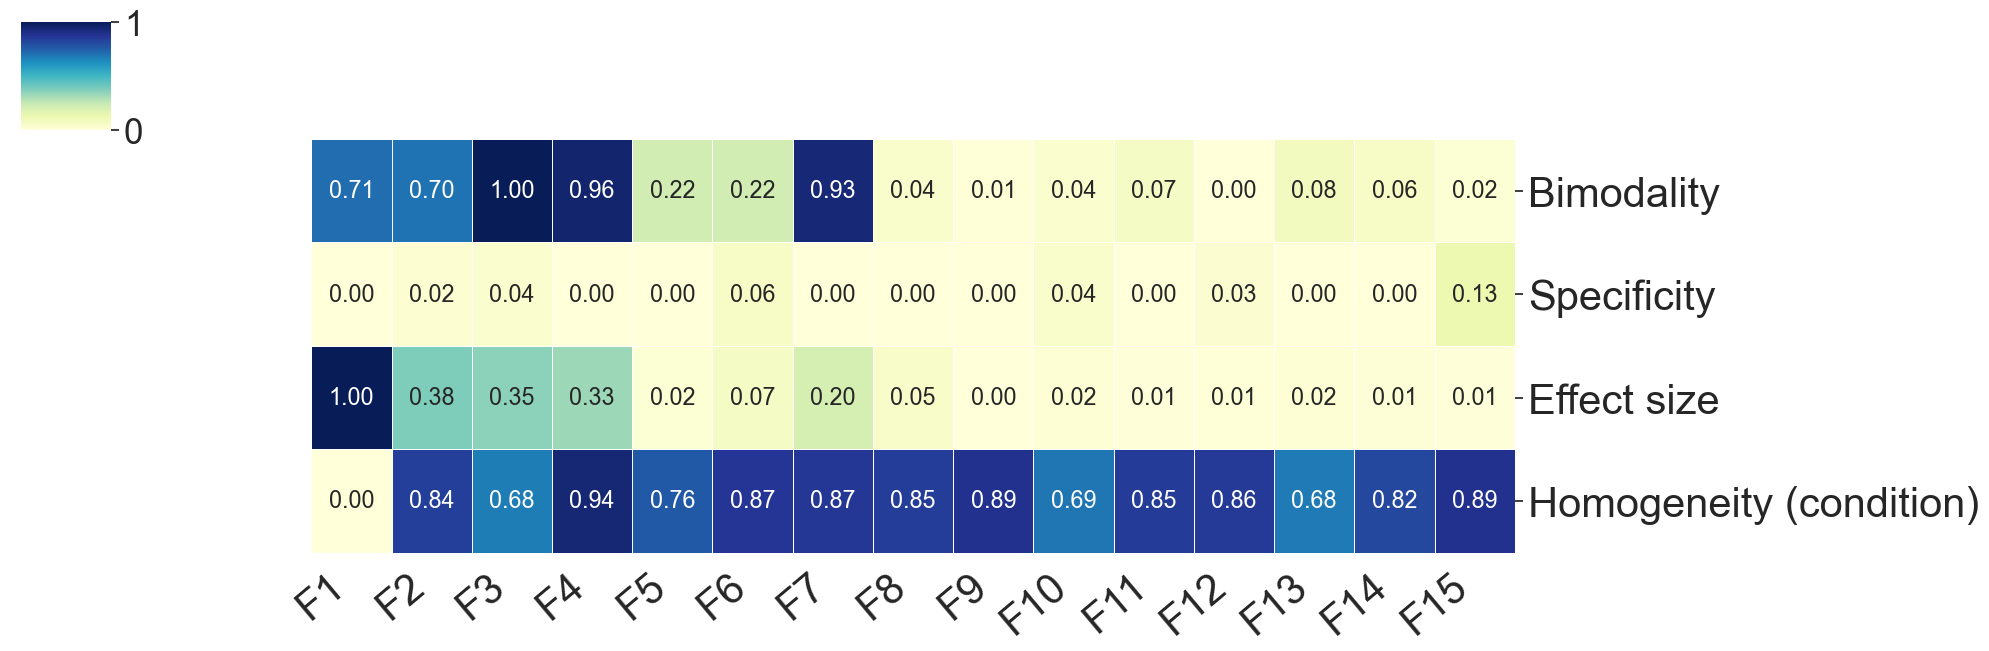

In [98]:
########### create factor-interpretibility score table (FIST) ######
metrics_dict = {'Bimodality':bimodality_score, 
                    'Specificity':simpson_fcat,
                    'Effect size': factor_variance,
                    'Homogeneity (condition)':asv_condition}

fist = met.FIST(metrics_dict)
### subset the first 15 factors of fist dataframe
vis.plot_FIST(fist.iloc[0:15,:])

# **Step 4: Biological Interpretation of a Selected Factor**

In [99]:
INTERESTING_FACTOR_ID = 0

# Get the loadings for the factor of interest
factor_loadings_for_factor_k = factor_loading[:, INTERESTING_FACTOR_ID]
gene_loadings = pd.Series(factor_loadings_for_factor_k, index=genes)
sorted_gene_loadings = gene_loadings.sort_values(ascending=False)

print(f"--- Top genes for Factor {INTERESTING_FACTOR_ID + 1} ---")

print("\n--- Top 20 Positive-Loading Genes (up-regulated in one condition) ---")
print(sorted_gene_loadings.head(20))

print("\n--- Top 20 Negative-Loading Genes (up-regulated in the other condition) ---")
print(sorted_gene_loadings.tail(20))

--- Top genes for Factor 1 ---

--- Top 20 Positive-Loading Genes (up-regulated in one condition) ---
Calm2       0.097961
Calm1       0.091674
Fth1        0.091046
Nrgn        0.090395
Ubb         0.085793
Atp6v0c     0.081876
Slc25a4     0.080989
C1ql3       0.079091
Actb        0.077923
Tmsb4x      0.077697
Atp1b1      0.077641
Hsp90ab1    0.077401
Gapdh       0.075632
Eef1a1      0.071437
Rpl6        0.071217
Dynll1      0.069636
Aplp1       0.068414
Atp5b       0.067767
Pcsk1n      0.067254
H3f3b       0.067187
dtype: float64

--- Top 20 Negative-Loading Genes (up-regulated in the other condition) ---
Adcy9      -0.033746
Aak1       -0.033986
Cacna1a    -0.034402
Lmo7       -0.034763
Lyst       -0.034840
Dennd1b    -0.035174
Enox1      -0.035705
Brinp1     -0.037069
Csmd2      -0.037437
Dmd        -0.037526
Adcy2      -0.038020
Otud7a     -0.038894
Gucy1a2    -0.039367
Ppm1h      -0.039405
Cep112     -0.040460
Frmpd4     -0.040889
Myo9a      -0.041008
Kcnq1ot1   -0.042901
Clstn2  

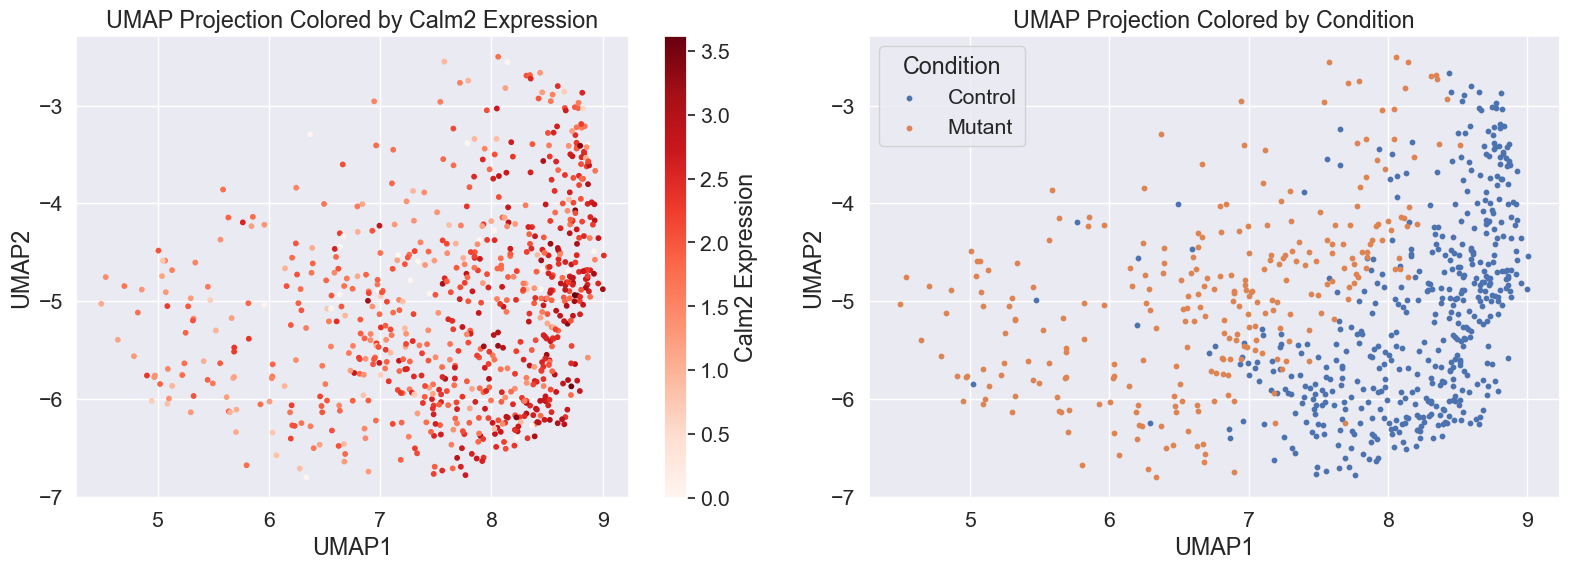

In [101]:
gene_of_interest = "Calm2"

expr = data[:, gene_of_interest].X
if hasattr(expr, "toarray"):
    expr = expr.toarray().flatten()
else:
    expr = np.array(expr).flatten()

umap_coords = data.obsm["X_umap"]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot UMAP colored by gene expression on the first subplot
sc = axs[0].scatter(umap_coords[:, 0], umap_coords[:, 1], c=expr, cmap='Reds', s=10)
axs[0].set_xlabel("UMAP1")
axs[0].set_ylabel("UMAP2")
axs[0].set_title(f"UMAP Projection Colored by {gene_of_interest} Expression")
fig.colorbar(sc, ax=axs[0], label=f"{gene_of_interest} Expression")

# Plot UMAP colored by condition on the second subplot
conditions = data.obs["condition"]
for cond in conditions.unique():
    idx = conditions == cond
    axs[1].scatter(umap_coords[idx, 0], umap_coords[idx, 1], s=10, label=cond)
axs[1].set_xlabel("UMAP1")
axs[1].set_ylabel("UMAP2")
axs[1].set_title("UMAP Projection Colored by Condition")
axs[1].legend(title="Condition")

plt.tight_layout()
plt.show()

Mitochondrial genes associated factor

In [102]:
INTERESTING_FACTOR_ID = 6
factor_loadings_for_factor_k = factor_loading[:, INTERESTING_FACTOR_ID]
gene_loadings = pd.Series(factor_loadings_for_factor_k, index=genes)
sorted_gene_loadings = gene_loadings.sort_values(ascending=False)

print(f"--- Top genes for Factor {INTERESTING_FACTOR_ID + 1} ---")

print("\n--- Top 20 Positive-Loading Genes (up-regulated in one condition) ---")
print(sorted_gene_loadings.head(20))

print("\n--- Top 20 Negative-Loading Genes (up-regulated in the other condition) ---")
print(sorted_gene_loadings.tail(20))

--- Top genes for Factor 7 ---

--- Top 20 Positive-Loading Genes (up-regulated in one condition) ---
mt-Co3     0.171049
mt-Nd4     0.164249
mt-Nd1     0.144247
mt-Nd2     0.138610
mt-Co1     0.138491
mt-Atp6    0.133739
mt-Co2     0.131005
Ppp3r1     0.108812
Camk1d     0.103886
Cmss1      0.101756
mt-Cytb    0.100930
Lars2      0.100429
Ncdn       0.091504
Pgm2l1     0.091357
Cplx2      0.090182
Hexb       0.087061
Ywhaz      0.085227
Adcy1      0.082937
Purb       0.080086
Zbtb18     0.075876
dtype: float64

--- Top 20 Negative-Loading Genes (up-regulated in the other condition) ---
Gtdc1                -0.042727
Rasa1                -0.043074
Opcml                -0.043772
Stxbp5l              -0.043956
Slf2                 -0.044212
Psmd14               -0.044679
Slc22a17             -0.044921
Strbp                -0.045855
Tafa2                -0.047031
Dync1i2              -0.047552
Rpl6                 -0.047819
Fgfr2                -0.048655
Jpx                  -0.050059
Smg

In [103]:
# gene_of_interest = ["mt-Co3", "mt-Nd4", "mt-Nd1", "mt-Nd2", "mt-Co1", "mt-Atp6", "mt-Co2"]
gene_of_interest = [gene for gene in data.var_names if gene.startswith("mt-")]
print(gene_of_interest)

['mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']


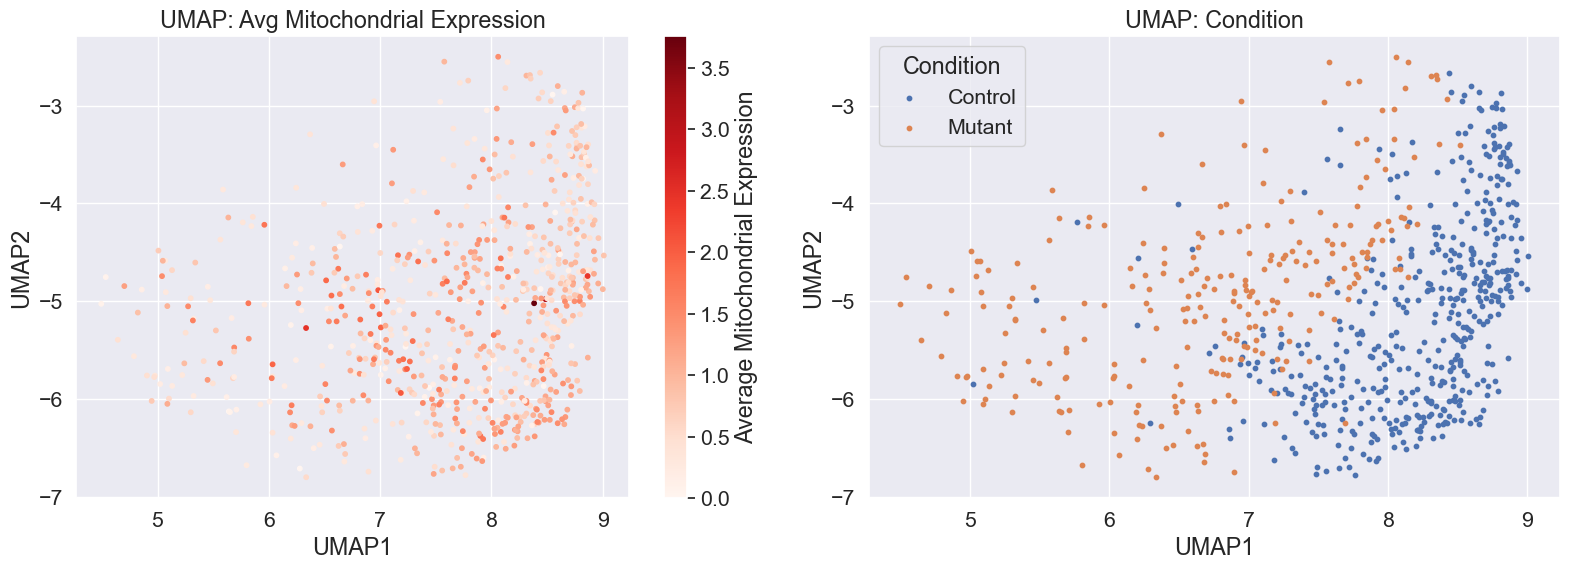

In [105]:
# Extract expression for the selected mitochondrial genes
expr = data[:, gene_of_interest].X
if hasattr(expr, "toarray"):
    expr = expr.toarray()
else:
    expr = np.array(expr)

# print(expr[:5, :5])
# Aggregate the expression across the selected genes per cell (using the mean)
expr = expr.mean(axis=1)

umap_coords = data.obsm["X_umap"]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot UMAP colored by the aggregated mitochondrial gene expression on the first subplot
sc = axs[0].scatter(umap_coords[:, 0], umap_coords[:, 1], c=expr, cmap='Reds', s=10)
axs[0].set_xlabel("UMAP1")
axs[0].set_ylabel("UMAP2")
axs[0].set_title("UMAP: Avg Mitochondrial Expression")
fig.colorbar(sc, ax=axs[0], label="Average Mitochondrial Expression")

# Plot UMAP colored by condition on the second subplot
conditions = data.obs["condition"]
for cond in conditions.unique():
    idx = conditions == cond
    axs[1].scatter(umap_coords[idx, 0], umap_coords[idx, 1], s=10, label=cond)
axs[1].set_xlabel("UMAP1")
axs[1].set_ylabel("UMAP2")
axs[1].set_title("UMAP: Condition")
axs[1].legend(title="Condition")

plt.tight_layout()
plt.show()

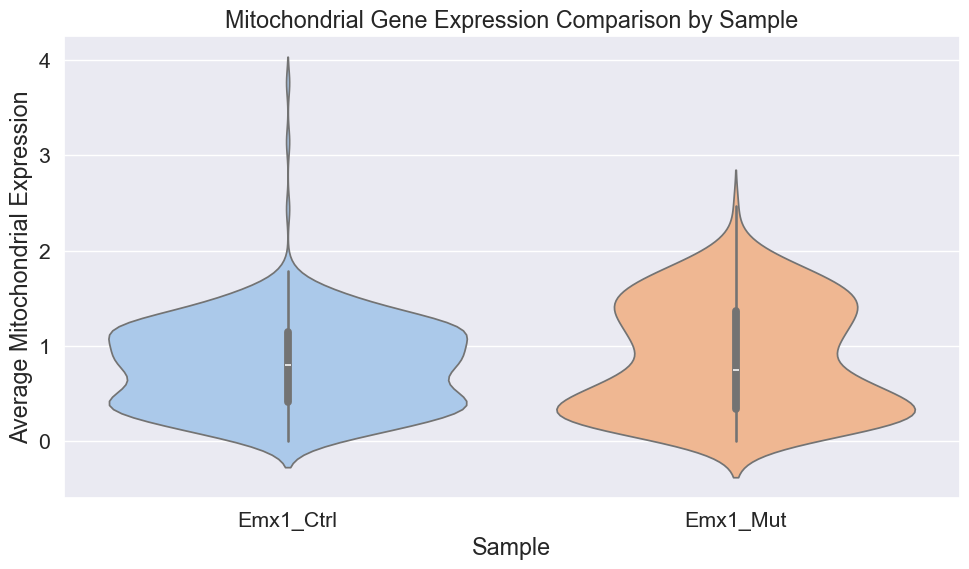

In [106]:
violin_df = pd.DataFrame({
    "Sample": data.obs["sample"],
    "Avg_Mito_Expression": expr
})

plt.figure(figsize=(10, 6))
sns.violinplot(x="Sample", y="Avg_Mito_Expression", hue="Sample", data=violin_df,
               inner="box", palette="pastel", density_norm="width", legend=False)
plt.xlabel("Sample")
plt.ylabel("Average Mitochondrial Expression")
plt.title("Mitochondrial Gene Expression Comparison by Sample")
plt.tight_layout()
plt.show()

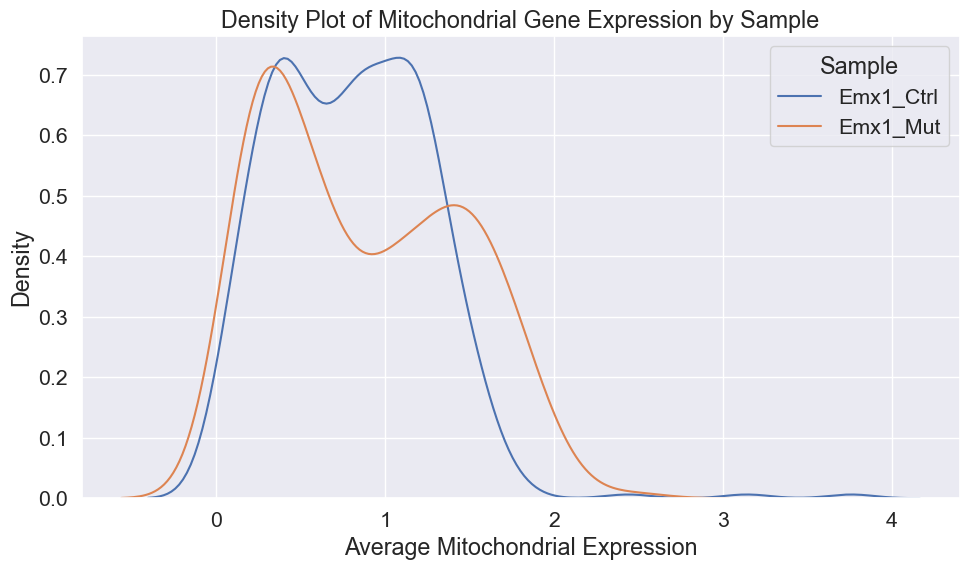

In [107]:
# Create a DataFrame pairing each cell's aggregated mitochondrial expression with its corresponding sample
density_df = pd.DataFrame({
    "Sample": data.obs["sample"],
    "Avg_Mito_Expression": expr
})

plt.figure(figsize=(10, 6))
# Loop over each sample and plot an overlying density curve (using a KDE) for its Avg_Mito_Expression
for sample in density_df["Sample"].unique():
    sample_data = density_df[density_df["Sample"] == sample]["Avg_Mito_Expression"]
    sns.kdeplot(sample_data, label=sample)

plt.xlabel("Average Mitochondrial Expression")
plt.ylabel("Density")
plt.title("Density Plot of Mitochondrial Gene Expression by Sample")
plt.legend(title="Sample")
plt.tight_layout()
plt.show()

# Modify sciRED functions to maintain directionality information

In [108]:
def get_AUC_all_factors_alevel_directional(factor_scores, a_binary_cov) -> np.ndarray:
    '''
    calculate the AUC of all the factors for a covariate level, preserving directionality.
    return a list of AUCs for all the factors
    factor_scores: a matrix of factor scores
    a_binary_cov: a binary vector of the covariate
    '''
    AUC_alevel_factors = []
    wilcoxon_pvalue_alevel_factors = []
    for i in range(factor_scores.shape[1]):
        a_factor = factor_scores[:,i]
        AUC, wilcoxon_pvalue = efca.get_AUC_alevel(a_factor, a_binary_cov)

        # Do NOT take absolute value or scale to 0-1 range
        AUC_alevel_factors.append(AUC)
        wilcoxon_pvalue_alevel_factors.append(wilcoxon_pvalue)
    ### convert to numpy array
    AUC_alevel_factors = np.asarray(AUC_alevel_factors)
    return AUC_alevel_factors


def get_importance_df_directional(factor_scores, a_binary_cov, time_eff=True) -> pd.DataFrame:
    '''
    calculate the importance of each factor for each covariate level, preserving directionality.
    factor_scores: numpy array of the factor scores for all the cells (n_cells, n_factors)
    a_binary_cov: numpy array of the binary covariate for a covariate level (n_cells, )
    time_eff: if True, skip RandomForest which is time consuming
    '''

    models = {'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter=500),
              'DecisionTree': DecisionTreeClassifier(),
              'RandomForest': RandomForestClassifier(),
              'XGB': XGBClassifier(),
              'KNeighbors_permute': KNeighborsClassifier()}
    
    if time_eff:
        ### remove RandomForest, KN from the models dictionary
        models.pop('RandomForest')
        models.pop('KNeighbors_permute')
        
    importance_dict = {}

    for model_name, model in models.items():
        X, y = factor_scores, a_binary_cov
        model.fit(X, y)

        if model_name == 'LogisticRegression':
            # Use raw coefficients for directionality
            importance_dict[model_name] = model.coef_[0]

        elif model_name in ['DecisionTree', 'RandomForest', 'XGB']:
            # get importance values (these are inherently non-directional, but included for completeness)
            importance_dict[model_name] = model.feature_importances_

        elif model_name == 'KNeighbors_permute':
            # perform permutation importance (these are inherently non-directional, but included for completeness)
            perm_results = permutation_importance(model, X, y, scoring='accuracy')
            importance_dict[model_name] = perm_results.importances_mean # Keep raw mean, not absolute
    
    #### adding AUC as a measure of importance, preserving directionality
    AUC_alevel = get_AUC_all_factors_alevel_directional(factor_scores, a_binary_cov)
    importance_dict['AUC'] = AUC_alevel

    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index',
                                           columns=['F'+str(i) for i in range(1, factor_scores.shape[1]+1)])
    return importance_df


def get_mean_importance_level_directional(importance_df_a_level, scale, mean) -> np.ndarray:
    '''
    calculate the mean importance of one level of a given covariate, preserving directionality.
    importance_df_a_level: a dataframe of the importance of each factor for a given covariate level
    scale: 'standard', 'minmax' or 'rank'
    mean: 'arithmatic' or 'geometric'
    '''
    importance_df_np = np.asarray(importance_df_a_level)
    ### normalize the importance score of each classifier in importance_df_np matrix
    if scale == 'standard':
        ### scale each row of the importance_df_np ( a model's importance results) to have zero mean and unit variance
        importance_df_np = (importance_df_np - importance_df_np.mean(axis=1, keepdims=True))/importance_df_np.std(axis=1, keepdims=True)

    if scale == 'minmax':
        ### scale each row of the importance_df_np to be between 0 and 1
        # For minmax scaling with directionality, we need to handle negative values correctly.
        # This scaling will map the range [min, max] to [0, 1].
        # If you need to preserve negative values, a different scaling approach might be needed,
        # or simply skip minmax scaling for directional results.
        importance_df_np = (importance_df_np - importance_df_np.min(axis=1, keepdims=True))/(importance_df_np.max(axis=1, keepdims=True) - importance_df_np.min(axis=1, keepdims=True))
    
    if scale == 'rank':
        ### replace each row of the importance_df_np with its rank
        # Rank data is inherently non-directional, but included for consistency.
        importance_df_np = np.apply_along_axis(ss.rankdata, 1, importance_df_np)
        ### for each row, devide ranks to n (number of factors) to get a value between 0 and 1
        importance_df_np = importance_df_np/importance_df_np.shape[1]

    ### calculate the mean of the importance_df_np matrix
    if mean == 'arithmatic':
        # Do NOT take absolute value here
        importance_df = np.mean(importance_df_np, axis=0)

    if mean == 'geometric':
        # Geometric mean requires positive values. If directional scores include negatives,
        # geometric mean is not appropriate. For now, we'll keep the original behavior
        # of replacing zeros/negatives with a small positive value, but this will
        # lose true negative directionality for geometric mean.
        # A warning or error might be appropriate here in a production system.
        #### if any value in a column is equal to zero, add a small value
        if np.any(importance_df_np == 0):
                importance_df_np[importance_df_np == 0] = 1e-10
        ### if any value is less than zero, replace with absolute value (this will lose directionality for geometric mean)
        if np.any(importance_df_np < 0):
            importance_df_np[importance_df_np < 0] = np.abs(importance_df_np[importance_df_np < 0])
        ### calculate the geometric mean of each column
        importance_df = ss.gmean(importance_df_np, axis=0)

    return importance_df


def FCAT_directional(covariate_vec, factor_scores,
                     scale='standard', mean='arithmatic', time_eff=True) -> pd.DataFrame:
    '''
    calculate the mean importance of all levels of a given covariate, preserving directionality.
    Returns a dataframe of size (num_levels, num_components).
    covariate_vec: numpy array of the covariate vector (n_cells, )
    factor_scores: numpy array of the factor scores for all the cells (n_cells, n_factors)
    '''

    mean_importance_df = pd.DataFrame(columns=['F'+str(i) for i in range(1, factor_scores.shape[1]+1)])

    for covariate_level in np.unique(covariate_vec):
        a_binary_cov = efca.get_binary_covariate(covariate_vec, covariate_level)
        importance_df_a_level = get_importance_df_directional(factor_scores, a_binary_cov, time_eff=time_eff)
        mean_importance_a_level = get_mean_importance_level_directional(importance_df_a_level, scale, mean)

        mean_importance_df.loc[covariate_level] = mean_importance_a_level

    return mean_importance_df

In [ ]:
%%capture
# New directional FCAT call:
fcat_condition_directional = FCAT_directional(data.obs['condition'], factor_scores, scale='standard', mean='arithmatic')


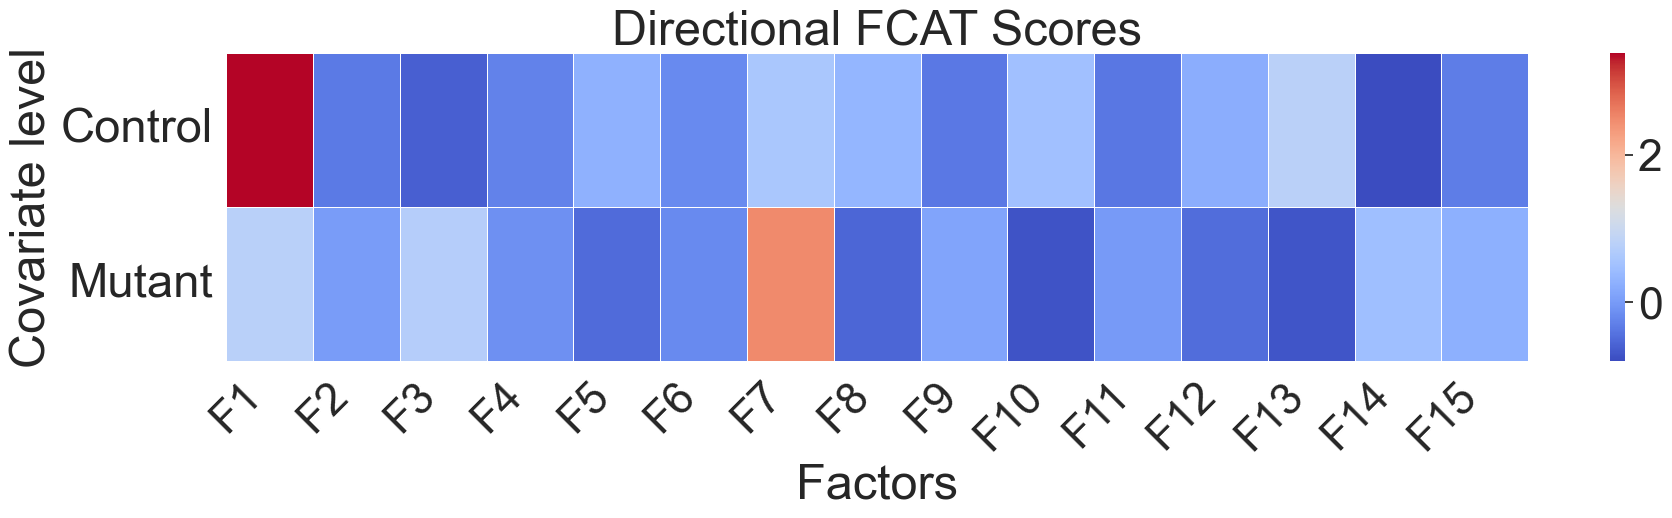

In [110]:
vis.plot_FCAT(fcat_condition_directional.iloc[:,0:15],title='Directional FCAT Scores', color='coolwarm',x_axis_fontsize=35,
              y_axis_fontsize=35, title_fontsize=35,
              x_axis_tick_fontsize=32, y_axis_tick_fontsize=34)